In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


RANDOM_SEED = 42
!pip freeze > requirements.txt

/kaggle/input/scoring-dataset/sample_submission.csv
/kaggle/input/scoring-dataset/train.csv
/kaggle/input/scoring-dataset/test.csv


In [2]:
train = pd.read_csv('../input/scoring-dataset/train.csv')
test = pd.read_csv('../input/scoring-dataset/test.csv')

In [3]:
train['test'] = 0
test['test'] = 1

In [4]:
data = pd.concat([train, test])

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту



Проверяем на пропуски в данных


In [6]:
data.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
test                    0
dtype: int64



Пропуски только в образовании (отсутствующие значения дефолта из тестового набора данных)




Заменяем пропущенные значения в столбце education на значение Missed


In [7]:
data['education'].fillna('Missed', inplace=True)



Преобразуем дату в формат datetime


In [8]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [9]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
19513,63934,2014-03-13,SCH,F,32,N,N,0,1,-2.387283,4,50,1,1,40000,1,4,Y,NaN,1
43143,40653,2014-02-17,SCH,F,60,N,N,0,0,-2.306343,2,50,2,3,6300,4,1,N,0.0,0
17635,10079,2014-01-17,SCH,F,50,N,N,0,0,-2.822362,1,20,2,3,14000,4,3,N,NaN,1
1742,10464,2014-01-17,SCH,M,35,N,N,0,0,-1.839669,2,50,1,1,20000,1,3,N,NaN,1
46701,58127,2014-03-06,SCH,M,47,Y,Y,0,0,-2.109858,1,40,1,2,22000,1,2,N,0.0,0




Добавим признаки 
* дней недели
* воскресения
* не рабочих дней


In [10]:
data['day_of_week'] = data['app_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x == 6 else 1)
data['non_working'] = data['day_of_week'].apply(lambda x: 0 if x < 5 else 1)

Добавим признак месяца подачи заявки



In [11]:
data['app_month'] = data['app_date'].dt.month_name()



Создадим timestamp из даты


In [12]:
data['app_date'] = (data['app_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")

In [13]:
data.isnull().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
test                    0
day_of_week             0
is_weekend              0
non_working             0
app_month               0
dtype: int64



Группируем столбцы по типу данных


In [14]:
cat_cols = ['education', 'home_address','work_address', 'sna', 'first_time', 'app_month', 'day_of_week']
bin_cols = ['car', 'car_type', 'good_work', 'foreign_passport', 'sex', 'is_weekend', 'non_working']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating', 'app_date']



Оценим числовые признаки


In [38]:
for c in num_cols:
    d = data[c]
    print(f"{c:20} | Max: {d.max():20} | Min: {d.min():20} | Median: {d.median():20} | Mean: {d.mean():20}")

age                  | Max:                   72 | Min:                   21 | Median:                 37.0 | Mean:   39.249409884882155
decline_app_cnt      | Max:                   33 | Min:                    0 | Median:                  0.0 | Mean:   0.2732051421723499
bki_request_cnt      | Max:                   53 | Min:                    0 | Median:                  1.0 | Mean:   2.0050023604604714
income               | Max:              1000000 | Min:                 1000 | Median:              30000.0 | Mean:   41012.648536514505
region_rating        | Max:                   80 | Min:                   20 | Median:                 50.0 | Mean:     56.7511893089298
app_date             | Max:           1398816000 | Min:           1388534400 | Median:         1393891200.0 | Mean:   1393802334.6334023




Не будем ничего отрезать. Распределение посмотрим позже




Прологарифмируем числовые переменные для нормализации распределения


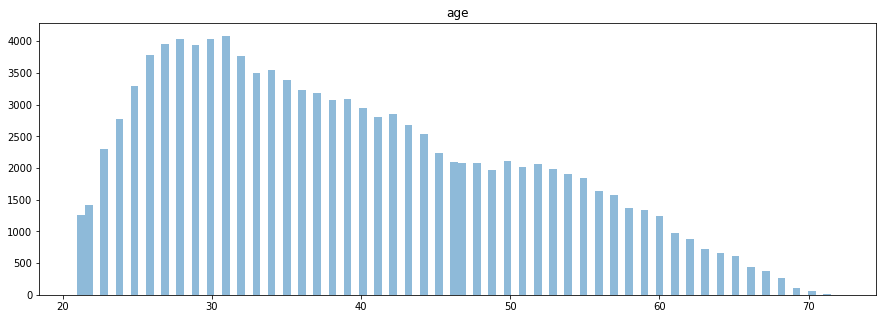

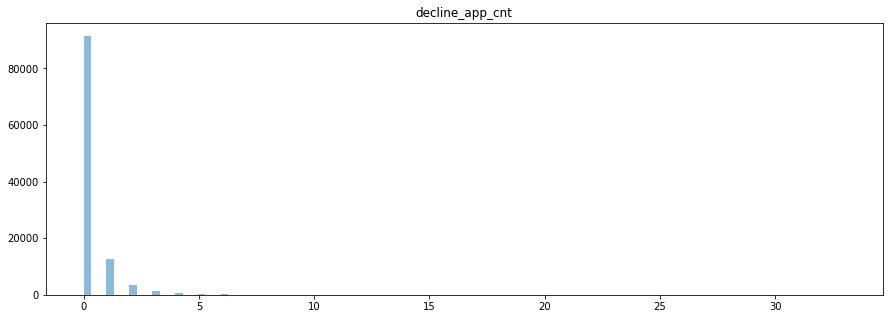

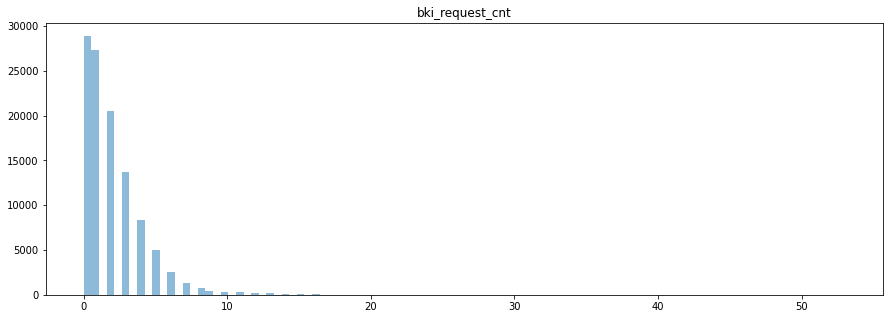

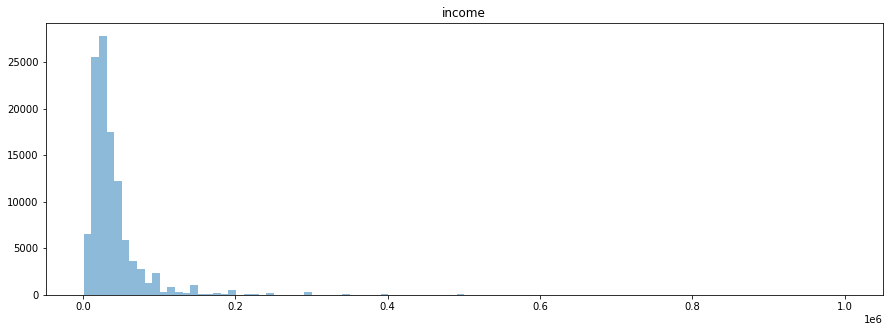

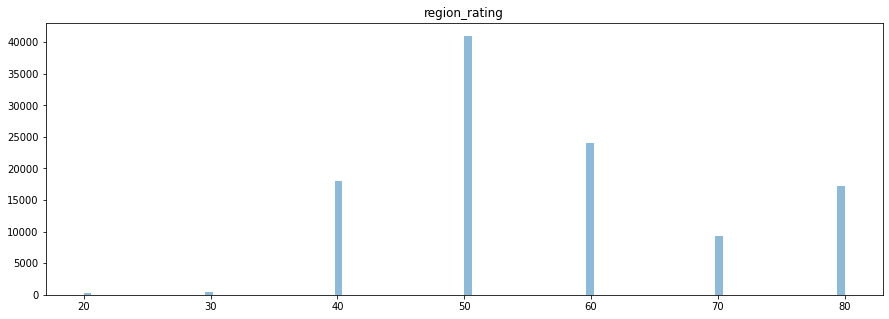

In [15]:
for i in num_cols:
    if i == 'app_date':
        continue
    fig = plt.figure(figsize=(15,5))
    plt.hist(data[i].dropna(), 100, alpha=0.5)
    plt.title(i)
    plt.show()

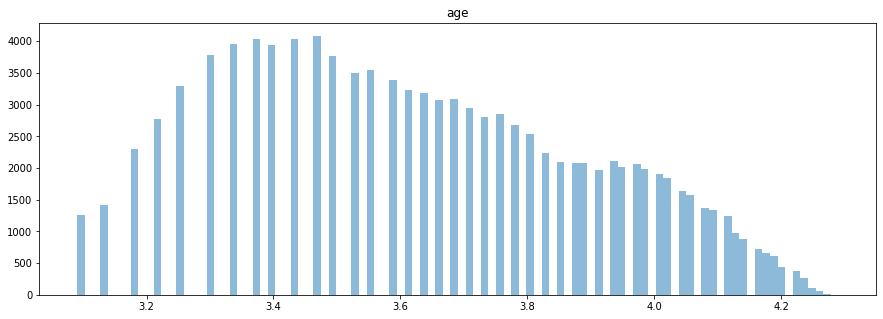

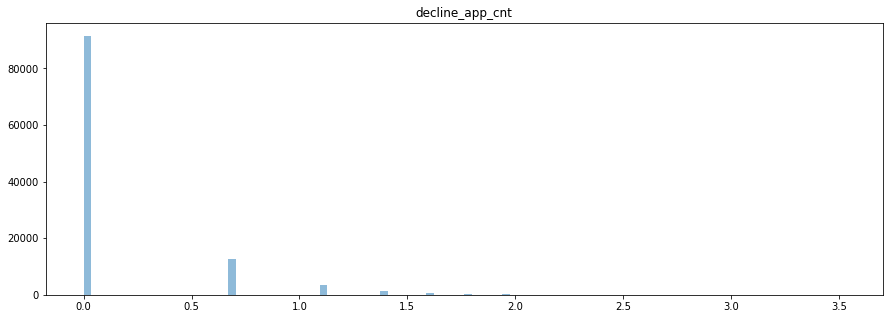

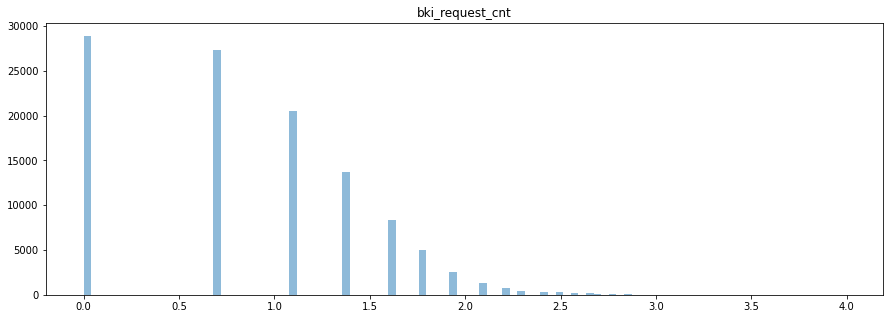

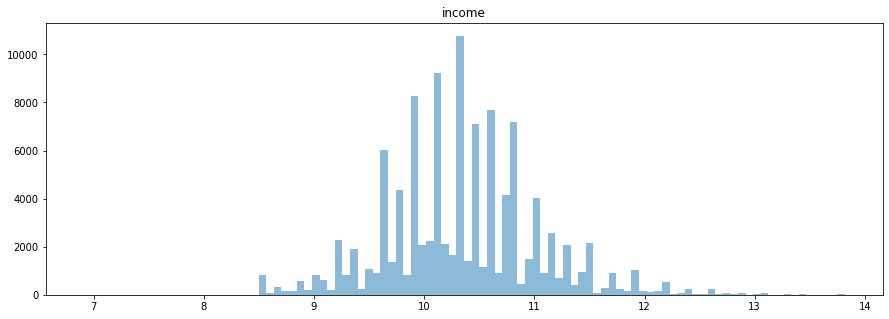

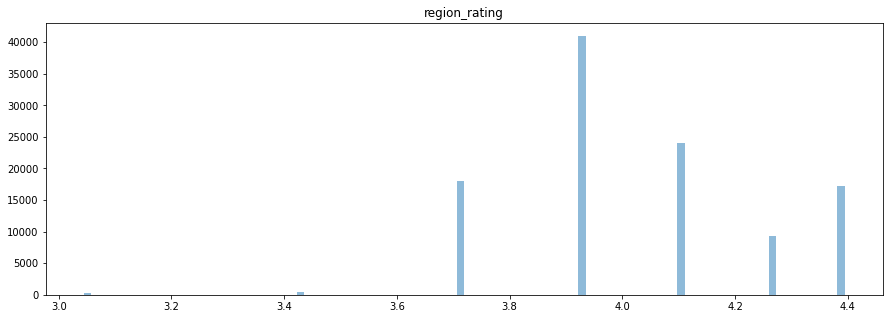

In [16]:
data_log = data.copy()

for i in num_cols:
    if i == 'app_date':
        continue
    data_log[i] = np.log(data[i] + 1) # Компенсация нуля
    fig = plt.figure(figsize=(15,5))
    plt.hist(data_log[i].dropna(), 100, alpha=0.5)
    plt.title(i)
    plt.show()



Посмотрим на максимальную корреляцию между признаками


In [17]:
from itertools import combinations

def get_corr(dataframe, name):
    digit_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    combinations_all = list(combinations(digit_columns, 2))
    corr = {}
    
    for c in combinations_all:
        col1 = dataframe[c[0]]
        col2 = dataframe[c[1]]
        corr[c] = col1.corr(other=col2)

    idx = pd.MultiIndex.from_tuples(corr.keys(), names=['A', 'B'])
    #corr = pd.Series(corr, index = idx).sort_values()
    corr = pd.DataFrame(list(corr.values()), index=idx,
                        columns=[name]).sort_values(by=name)
    return corr

corr = get_corr(data, 'general')
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 300)

perc25 = (abs(corr.max()) + abs(corr.min())) * \
    0.125  # ((abs(a) + abs(b)) / 2) * 0.25
display(corr[(corr < -perc25) | (corr > perc25)].dropna())

general
A             B                     
sna           first_time   -0.526594
region_rating income        0.207494
              home_address  0.232971
              work_address  0.254062
home_address  work_address  0.726535
day_of_week   non_working   0.739683
client_id     app_date      0.999581



Нет полностью скоррелированных признаков, которые мы могли бы удалить




Значимость непрерывных переменных


<AxesSubplot:>

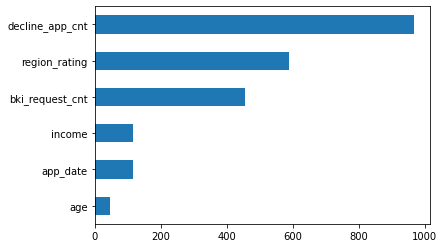

In [18]:
imp_num = pd.Series(f_classif(data[data['test'] == 0][num_cols], data[data['test'] == 0]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')



Количество отклоненных заявок - самый значимый признак.




Превращаем представление бинарных и категориальных признаков в числовое


In [19]:
label_encoder = LabelEncoder()

for column in bin_cols + cat_cols:
    data_log[column] = label_encoder.fit_transform(data_log[column])
    
# убедимся в преобразовании    
data_log.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test,day_of_week,is_weekend,non_working,app_month
0,25905,1391212800,4,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3.931826,0,1,9.798183,3,0,0,0.0,0,5,0,1,1
1,63161,1394582400,4,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3.931826,1,2,9.852247,3,0,0,0.0,0,2,0,0,3
2,25887,1391212800,4,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,4.394449,0,1,10.308986,0,3,1,0.0,0,5,0,1,1
3,16222,1390435200,4,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3.931826,1,2,9.210440,0,2,0,0.0,0,3,0,0,2
4,101655,1397779200,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4.110874,1,2,10.308986,0,3,1,0.0,0,4,0,0,0


Значимость бинарных и категориальных переменных


<AxesSubplot:>

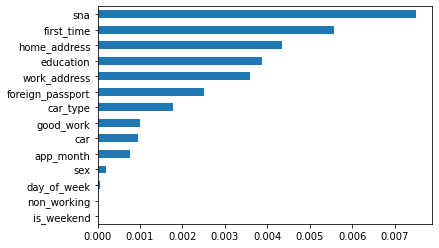

In [20]:
imp_cat = pd.Series(mutual_info_classif(data_log[data_log['test'] == 0][bin_cols + cat_cols], data_log[data_log['test'] == 0]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')



самый важный из категориальных признаков - sna - связь заемщика с клиентами банка




Нормализуем числовые данные


In [21]:
data_log[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data_log[num_cols]), columns = data_log[num_cols].columns)

In [22]:
data_log = pd.get_dummies(data_log, prefix=cat_cols, columns=cat_cols)

In [23]:
data_log.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,default,test,is_weekend,non_working,education_0,education_1,education_2,education_3,education_4,education_5,home_address_0,home_address_1,home_address_2,work_address_0,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3,app_month_0,app_month_1,app_month_2,app_month_3,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
41579,90031,1.060874,0,-0.888776,0,0,-0.418815,0,-1.592762,-0.281790,-1.408242,-0.955145,0,0.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
26533,101290,1.434987,0,0.454807,0,0,-0.418815,1,-2.013355,-0.281790,-1.408242,0.039807,0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
33643,22158,-1.027919,0,0.533644,1,0,-0.418815,1,-1.198102,-1.334144,0.355168,-0.052834,0,1.0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1994,1040,-1.776144,1,0.120447,0,0,-0.418815,0,-1.534912,-1.334144,-0.439531,-0.314543,0,0.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
59540,108551,1.746747,1,-0.249170,1,0,-0.418815,0,-1.765298,-0.281790,-0.439531,-0.786080,0,0.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0


Моделируем

In [32]:
X = data_log[data_log['test'] == 0][list(set(data_log.columns) - set(['default', 'test', 'client_id']))].values
Y = data_log[data_log['test'] == 0]['default'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

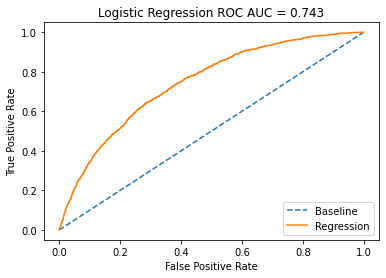

In [34]:
model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Попробуем метод главных компонент

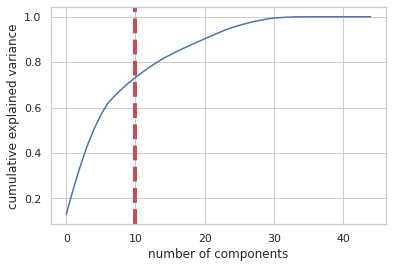

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.129219,0.129219
1,0.239845,0.110626
2,0.339654,0.099809
3,0.429336,0.089682
4,0.503828,0.074492
5,0.568338,0.064510
6,0.618669,0.050331
7,0.651934,0.033265
8,0.681025,0.029091
9,0.708548,0.027523


In [39]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=X_train.shape[1])
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
# function of calculating number of features for SVD & PCA
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [ ]:
select_n_components(evr, 0.9999)

In [ ]:
pca = PCA(n_components=select_n_components(evr, 0.9999))
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# run the model & predict data and probability of 1  with PCA
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').\
    fit(X_train_pca, y_train)
y_pred_pca = model.predict(X_test_pca)
probs = model.predict_proba(X_test_pca)[:, 1]
# probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=X.shape[1]-1)
X_tsvd = tsvd.fit(X)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

# calculate number of components which have 0.9999 cumulative variance ratio
select_n_components(tsvd_var_ratios, 0.9999)



In [ ]:
svd = TruncatedSVD(n_components = select_n_components(tsvd_var_ratios, 0.9999)).fit(X)

X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

In [ ]:
# run the model & predict data and probability of 1  with SVD
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced').\
    fit(X_train_svd, y_train)

y_pred_svd = model.predict(X_test_svd)
probs = model.predict_proba(X_test_svd)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [36]:
# select test data
test_data = data_log.copy()[data_log['test'] == 1]

X_test = test_data[list(set(data_log.columns) - set(['default', 'test', 'client_id']))].values
# # remove unnecessary columns

# # reduce number of features using pca model
# pca_test = pca.transform(test)

# # predict the data & prepare the submission file
model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED).\
    fit(X_train, y_train)


y_pred_final = model.predict_proba(X_test)[:, 1]
submission = pd.concat([test_data.client_id,pd.Series(y_pred_final,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)

In [37]:
submission

,client_id,default
0,74835,0.038357
1,17527,0.175969
2,75683,0.065101
3,26883,0.086935
4,28862,0.045259
...,...,...
36344,83775,0.231157
36345,106254,0.020614
36346,81852,0.137731
36347,1971,0.227341
